In [962]:
import numpy as np
import pandas as pd
import sklearn as skl
import quant_tools.portfolio_tools as pt
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

In [963]:
tickers = pd.read_csv(r'C:\Users\marcu\Documents\Quant\Programming\Data\sp500-master\sp500.csv').iloc[:, 0].head(30).values
tickers

array(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP',
       'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE',
       'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN',
       'AMCR', 'AMD', 'AEE', 'AAL'], dtype=object)

In [964]:
# Close Prices
close_asset_prices = pd.DataFrame()

# Returns of opening prices
open_asset_returns = pd.DataFrame()

# Returns of close prices
close_asset_returns = pd.DataFrame()

# tickers = ['GLD', 'SPY', 'AAPL', 'BIL']

for ticker in tickers:

    prices = yf.download(ticker, start='1970-01-01', end=dt.date.today())
    
    # Get i'th asset's returns
    close_prices = prices['Adj Close'].dropna()
    close_prices = close_prices.rename(ticker)
    close_rets = prices['Adj Close'].pct_change().dropna()
    close_rets = close_rets.rename(ticker)
    open_rets = prices['Open'].pct_change().dropna()
    open_rets = open_rets.rename(ticker)

    close_asset_prices = pd.concat([close_asset_prices, close_prices, ], axis=1)
    close_asset_returns = pd.concat([close_asset_returns, close_rets], axis=1)
    open_asset_returns = pd.concat([open_asset_returns, open_rets], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [980]:
from scipy.optimize import minimize as opt
from scipy.optimize import Bounds

# def dollar_risk_parity_obj(n_units: pd.Series, cov: pd.DataFrame, target_risk: float, portfoio_value: float) -> float:
#     """ Inspired by CTA and Trend Follwers' risk management practices, the Dollar Risk Parity objective function
#         targets "target_risk" percent risk per position (equal risk contribution) which represents 1 SD of the 
#         underlying instrument's price movement. Here, the covariance and variance of each asset defines its risk to account for
#         correlation structures and mitiage over exposure to a single risk factor.
               
#         Positions represent how many shares to purchase for a 1SD move in the underlying instrument 
#         to represent "target_risk" percent loss in "portfolio_value". This follows the risk management practices of 
#         select portfolio managers that target equal risk allocation to each trade/position, but leverages stop-losses 
#         (e.g., 1SD stop) to limit exogenous risk exposure.

#         This follows the intuition behind traditional equal variance contribution risk parity, but defines risk as dollar value
#         at risk (e.g., stop loss set at 1SD) instead of purely variance.          

#     Args:
#         n_units (pd.Series): number of units (e.g., shares, contracts) to purchase per portfolio constituent. 
#         cov (pd.DataFrame): covariance matrix of portfolio constituents' prices.
#         target_risk (float): target percent risk per position.
#         portfoio_value (float): portfolio dollar value.

#     Returns:
#         float
#     """

#     # N portfolio constituents
#     n = len(n_units)

#     # Get equal dollar risk contribution (representing target 1SD move in each instrument)
#     # equal_target_risk_contribution = np.array([target_risk] * n) * portfoio_value
#     equal_target_risk_contribution = np.array([1/n] * n)

#     # Get weighted asbolute risk (vols) - must be absolute value of risk since managers may encounter negative risk contribution
#     # weighted_absolute_risk = np.sqrt(np.abs(n_units.T.dot(cov) * n_units))
#     weighted_absolute_risk = n_units.T.dot(cov) * n_units

#     percent_risk_contribution = weighted_absolute_risk / weighted_absolute_risk.sum()


#     # Check if the 1SD dollar risk contribution of current portfolio = equal_target_risk_contribution
#     # Measure the absolute difference between current vs. equal risk contribution
#     # diff = np.abs((weighted_absolute_risk - equal_target_risk_contribution)).sum()
#     diff = np.abs((percent_risk_contribution - equal_target_risk_contribution)).sum()

#     # print(weighted_absolute_risk, equal_target_risk_contribution, diff, n_units)
#     print(percent_risk_contribution.round(3), equal_target_risk_contribution, diff)

#     return diff 

def dollar_risk_parity_obj(n_units: pd.Series, cov: pd.DataFrame) -> float:
    """ Inspired by CTA and Trend Follwers' risk management practices, the Dollar Risk Parity objective function
        targets "target_risk" percent risk per position (equal risk contribution) which represents 1 SDs of the 
        underlying instrument's price movement. Here, the covariance and variance of each asset defines its risk to account for
        correlation structures and mitiage over exposure to a single risk factor.
               
        Positions represent how many shares to purchase for an 1 SD move in the underlying instrument 
        to represent "target_risk" percent loss in "portfolio_value". This follows the risk management practices of 
        select portfolio managers that target equal risk allocation to each trade/position, but leverages stop-losses 
        (e.g., 1SD stop) to limit exogenous risk exposure.

        This follows the intuition behind traditional equal variance contribution risk parity algorithms, but defines risk as dollar value
        at risk (e.g., stop loss set at 1SD) instead of purely variance.          

    Args:
        n_units (pd.Series): number of units (e.g., shares, contracts) to purchase per portfolio constituent. 
        cov (pd.DataFrame): covariance matrix of portfolio constituents' prices.
        target_risk (float): target percent risk per position.
        portfoio_value (float): portfolio dollar value.

    Returns:
        float
    """

    # N portfolio constituents
    n = len(n_units)

    # Get equal percent risk contribution (representing target 1SD move in each instrument)
    equal_risk_contribution = np.array([1/n] * n) 

    # Get portfolio dollar variance
    variance = n_units.T.dot(cov).dot(n_units)
    # Get weighted risk (respective dollar variance)    
    weighted_dollar_risk = n_units.T.dot(cov) * n_units
    # Get percent weighted risk contribution (percent contribution to variance)
    percent_risk_contribution = weighted_dollar_risk / variance

    # Check if the dollar risk contribution of current portfolio = equal_risk_contribution
    # Measure the absolute difference between current vs. equal risk contribution
    diff = np.abs((percent_risk_contribution - equal_risk_contribution)).sum()

    return diff 

def dollar_risk_parity(prices: pd.DataFrame, target_risk = 0.001, portfoio_value = 100000, long_only=False) -> pd.Series:
    """ Inspired by CTA and Trend Follwers' risk management practices, the Dollar Risk Parity optimization function
        targets "target_risk" percent risk per position (equal risk contribution) which represents 1 SD of the 
        underlying instrument's price movement. Here, the covariance and variance of each asset defines its risk to account for
        correlation structures and mitiage over exposure to a single risk factor.
               
        Positions represent how many shares to purchase for a 1SD move in the underlying instrument 
        to represent "target_risk" percent loss in "portfolio_value". This follows the risk management practices of 
        select portfolio managers that target equal risk allocation to each trade/position, but leverages stop-losses 
        (e.g., 1SD stop) to limit exogenous risk exposure.

        This follows the intuition behind traditional equal variance contribution risk parity, but defines risk as dollar value
        at risk (e.g., stop loss set at 1SD) instead of purely variance. 

    Args:
        prices (pd.DataFrame): _description_
        target_risk (float, optional): _description_. Defaults to 0.005.
        portfoio_value (int, optional): _description_. Defaults to 100000.

    Returns:
        pd.Series: _description_
    """

    # Determine risk definition
    objective_function = dollar_risk_parity_obj

    n = len(prices.columns)

    # Covariance of prices
    cov = prices.cov() 

    initial_guess = pd.Series(np.array([1/n] * n), index=prices.columns)

    constraints =   [# Ensure notional exposure < portfolio_value (i.e., no leverage)
                    {"type": "ineq", "fun": lambda n_units: portfoio_value - (n_units*prices.iloc[-1]).sum()}
                    ]

    # Long-Only or L/S
    if long_only:
        bounds = Bounds(0, np.inf)
        # bounds = Bounds(0, 10000000000)
    else:
        bounds = Bounds(-np.inf, np.inf)
        # bounds = Bounds(-10000000000, 10000000000)
    
    # Get dollar risk parity weights
    n_units = opt(objective_function, 
            initial_guess, 
            bounds=bounds,
            args=(cov),
            method='SLSQP',
            constraints=constraints)['x']

    n_units = pd.Series(n_units, index=cov.index)

    ex_ante_dollar_vol = np.sqrt(n_units.T.dot(cov).dot(n_units))
    print(f"Target Portfolio Risk: {portfoio_value*n*target_risk}")
    
    risk_scalar = portfoio_value*n*target_risk / ex_ante_dollar_vol

    n_units *= risk_scalar
    ex_ante_scaled_dollar_vol = np.sqrt(n_units.T.dot(cov).dot(n_units))
    print(f"Ex-Ante Portfolio Risk: {ex_ante_scaled_dollar_vol}")
    print(f"Ex-Ante Dollar Risk Contributions: \n{(n_units.T.dot(cov) *  n_units)**.5}" )

    return n_units

In [981]:
portfolio_value = 1000000

In [1010]:
n = close_asset_prices.columns.size
sd2_pct_move = .2
sd2_VaR = sd2_pct_move / n
sd1_VaR = sd2_VaR / 2

In [1014]:
dollar_risk_parity_w = dollar_risk_parity(prices = close_asset_prices.tail(1000), target_risk = sd1_VaR, portfoio_value = portfolio_value, long_only=True)
dollar_risk_parity_w

Target Portfolio Risk: 100000.0
Ex-Ante Portfolio Risk: 100000.00000000001
Ex-Ante Dollar Risk Contributions: 
MMM      18278.234186
AOS      18391.424244
ABT      18393.541856
ABBV     18406.324963
ACN      18599.398662
ATVI     18451.824740
ADM      18417.109456
ADBE     18907.697958
ADP      18417.220673
AAP      18598.369028
AES      18601.018585
AFL      18288.306531
A        19083.163239
APD      18364.594776
AKAM     18570.529169
ALK      20615.804123
ALB      18314.267330
ARE      18438.721672
ALGN     18301.533003
ALLE     18259.932844
LNT      18736.549733
ALL      18329.042023
GOOGL    18652.061107
GOOG     18356.119634
MO       18292.849074
AMZN     19017.919394
AMCR     18570.726233
AMD      18403.110129
AEE      18305.973269
AAL               NaN
dtype: float64


MMM      3.441860e+02
AOS      3.176198e+02
ABT      2.272889e+02
ABBV     1.580969e+02
ACN      6.271953e+01
ATVI     3.929918e+02
ADM      2.525448e+02
ADBE     4.488586e+01
ADP      1.212494e+02
AAP      1.266786e+02
AES      8.745483e+02
AFL      5.046822e+02
A        1.302477e+02
APD      1.453678e+02
AKAM     5.026223e+02
ALK      1.292037e+03
ALB      5.500708e+01
ARE      1.910831e+02
ALGN     2.726032e+01
ALLE     3.216274e+02
LNT      8.580738e+02
ALL      2.657369e+02
GOOGL    1.308104e+02
GOOG     1.247017e+02
MO       7.985885e+02
AMZN     1.775882e+02
AMCR     3.141030e+03
AMD      1.360161e+02
AEE      5.654503e+02
AAL      1.148743e-15
dtype: float64

In [1015]:
# Get dollar exposure
notional_exposure = close_asset_prices.iloc[-1].dot(dollar_risk_parity_w)
# Get pct exposure
notional_pct_exposure = notional_exposure / portfolio_value
# Get portfolio weights for tradable capital
weights = dollar_risk_parity_w / dollar_risk_parity_w.sum()

print(notional_exposure, notional_pct_exposure, weights)

789081.0641058137 0.7890810641058137 MMM      2.800368e-02
AOS      2.584220e-02
ABT      1.849270e-02
ABBV     1.286309e-02
ACN      5.102990e-03
ATVI     3.197462e-02
ADM      2.054757e-02
ADBE     3.652006e-03
ADP      9.865103e-03
AAP      1.030683e-02
AES      7.115506e-02
AFL      4.106198e-02
A        1.059722e-02
APD      1.182743e-02
AKAM     4.089439e-02
ALK      1.051228e-01
ALB      4.475490e-03
ARE      1.554691e-02
ALGN     2.217955e-03
ALLE     2.616827e-02
LNT      6.981465e-02
ALL      2.162090e-02
GOOGL    1.064301e-02
GOOG     1.014598e-02
MO       6.497481e-02
AMZN     1.444895e-02
AMCR     2.555607e-01
AMD      1.106655e-02
AEE      4.600620e-02
AAL      9.346411e-20
dtype: float64


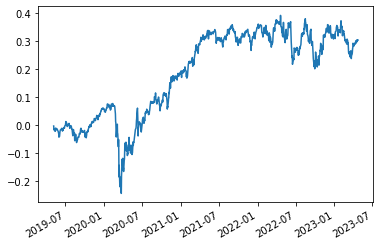

<AxesSubplot:>

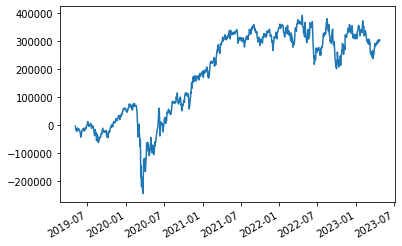

In [1016]:
# Get weighted returns & scale based on pct notional exposure
raw_rets = (close_asset_returns.tail(1000)*weights).sum(1)*notional_pct_exposure
pt.cumulative_returns(raw_rets).plot()
plt.show()
# Scale returns according to portfolio value of $100k
(portfolio_value*pt.cumulative_returns(raw_rets)).plot()

<AxesSubplot:>

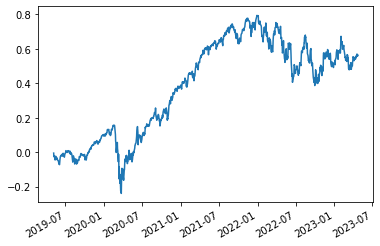

In [1017]:
pt.cumulative_returns((close_asset_returns.tail(1000) / 30).sum(1)).plot()

In [1018]:
pt.performance_summary(raw_rets), pt.performance_summary((close_asset_returns.tail(1000).tail(500) / 30).sum(1))

(                             Performance Summary
 Sharpe Ratio                               0.455
 Drift Adjusted Sharpe Ratio                0.356
 CAGR                                       0.070
 Vol                                        0.184
 Sortino Ratio                              0.555
 Martin (Ulcer) Ratio                       1.392
 Omega Ratio                                1.017
 RR Ratio                                   1.092
 Win Rate                                   0.527
 Skew                                      -0.725
 Kurtosis                                  16.192
 Max Drawdown                              -0.298
 VaR - Laplace                             -0.044
 CVaR - Laplace                            -0.055
 Tail-Risk Density                          0.005,
                              Performance Summary
 Sharpe Ratio                               0.042
 Drift Adjusted Sharpe Ratio               -0.338
 CAGR                                      -0.014